TODO: (Research)
- fluorescence injection data
- 2 tasks: boundary, and distance from the injection spot to the bottom of the boundary 


U-Net notes

- classification: maps each pixel to a label 
- encoder: compress image data to a smaller space
- decoder: map the data back to labels(?)
- similar process as PCA(?)
- composed of building blocks 
- convolutional layer + pooling layer
- learns through gradient descent
- each layer reduces the dimension of the image 

def(train)
- x is image, y is labels 

hyperparameter optimization:
- just use Charlie's settings mostly 
- learning rate 
- maybe experiment with kernel size 

TODO:
 
- try running Charlie's unet on general data on the internet, and biomedical data

# TODO: Injection data

explore de-noising techniques to improve the signal-to-noise ratio
- there is a lot of white noise masking the actual data -> maybe gaussian blur, moving average not very helpful
- read about: diffusion model?

TODO: 

- consider using skimage for precision tasks and cv2 for general manipulation / efficiency

In [26]:
import numpy as np

x = [0.1, 0.01, 0.001, 0.0001]
nx = [-el for el in x]

# print(f"Let f(x) = sin(2x)/(3x)")
# print(f" Let x = {x}. Then, ")
for num in x:
    print(f"f({num}) = {np.sin(2*num)/3/num}" )
    # print(f"f({-num}) = {np.sin(2*-num)/3/-num}")
    

f(0.1) = 0.662231102650204
f(0.01) = 0.6666222231111026
f(0.001) = 0.6666662222223111
f(0.0001) = 0.6666666622222223


non-local means denoising https://scikit-image.org/docs/stable/auto_examples/filters/plot_nonlocal_means.html

Estimated noise standard deviation = 0.07870838493145946
PSNR (noisy) = 22.15
PSNR (slow) = 29.36
PSNR (slow, using sigma) = 29.74
PSNR (fast) = 28.94
PSNR (fast, using sigma) = 29.33


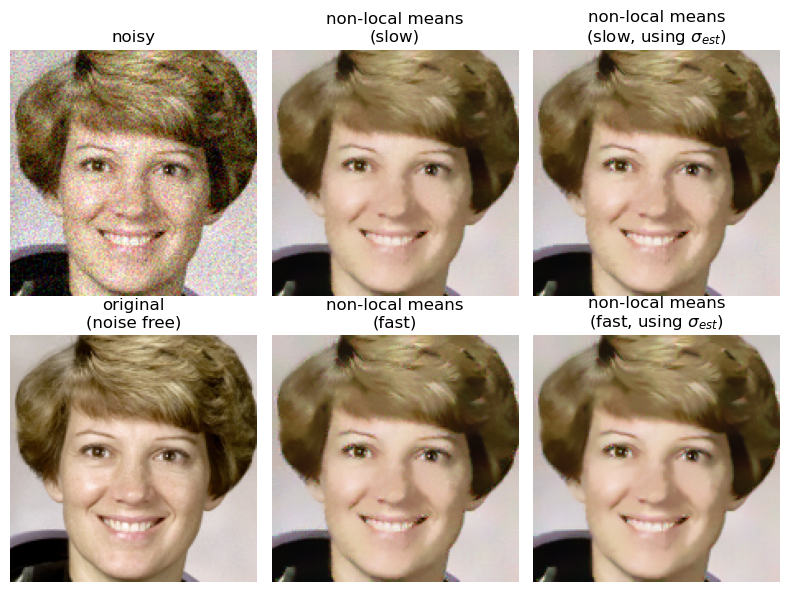

: 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise
from skimage import restoration


astro = img_as_float(data.astronaut())
astro = astro[30:180, 150:300]

sigma = 0.08
noisy = random_noise(astro, var=sigma**2)

# # estimate the noise standard deviation from the noisy image
# sigma_est = np.mean(estimate_sigma(noisy, channel_axis=-1))
# print(f'estimated noise standard deviation = {sigma_est}')


# Estimate noise for each channel separately
sigma_est_r = restoration.estimate_sigma(noisy[..., 0])  # Red channel
sigma_est_g = restoration.estimate_sigma(noisy[..., 1])  # Green channel
sigma_est_b = restoration.estimate_sigma(noisy[..., 2])  # Blue channel

# Average the noise estimates across channels
sigma_est = np.mean([sigma_est_r, sigma_est_g, sigma_est_b])

print(f'Estimated noise standard deviation = {sigma_est}')

patch_kw = dict(
    patch_size=5,  # 5x5 patches
    patch_distance=6,  # 13x13 search area
    channel_axis=-1,
)

# slow algorithm
denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False, **patch_kw)

# slow algorithm, sigma provided
denoise2 = denoise_nl_means(
    noisy, h=0.8 * sigma_est, sigma=sigma_est, fast_mode=False, **patch_kw
)

# fast algorithm
denoise_fast = denoise_nl_means(noisy, h=0.8 * sigma_est, fast_mode=True, **patch_kw)

# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(
    noisy, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6), sharex=True, sharey=True)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('noisy')
ax[0, 1].imshow(denoise)
ax[0, 1].axis('off')
ax[0, 1].set_title('non-local means\n(slow)')
ax[0, 2].imshow(denoise2)
ax[0, 2].axis('off')
ax[0, 2].set_title('non-local means\n(slow, using $\\sigma_{est}$)')
ax[1, 0].imshow(astro)
ax[1, 0].axis('off')
ax[1, 0].set_title('original\n(noise free)')
ax[1, 1].imshow(denoise_fast)
ax[1, 1].axis('off')
ax[1, 1].set_title('non-local means\n(fast)')
ax[1, 2].imshow(denoise2_fast)
ax[1, 2].axis('off')
ax[1, 2].set_title('non-local means\n(fast, using $\\sigma_{est}$)')

fig.tight_layout()

# print PSNR metric for each case
psnr_noisy = peak_signal_noise_ratio(astro, noisy)
psnr = peak_signal_noise_ratio(astro, denoise)
psnr2 = peak_signal_noise_ratio(astro, denoise2)
psnr_fast = peak_signal_noise_ratio(astro, denoise_fast)
psnr2_fast = peak_signal_noise_ratio(astro, denoise2_fast)

print(f'PSNR (noisy) = {psnr_noisy:0.2f}')
print(f'PSNR (slow) = {psnr:0.2f}')
print(f'PSNR (slow, using sigma) = {psnr2:0.2f}')
print(f'PSNR (fast) = {psnr_fast:0.2f}')
print(f'PSNR (fast, using sigma) = {psnr2_fast:0.2f}')

plt.show()